### Transfer Learning
### Fine-tuning VGG16 on Cats & Dogs dataset
In this tutorial we will learn how to fine-tune a pre-trained network on a new dataset.
We will perform the following steps:
1. Load and normalizing the cats & dogs dataset
2. Load pre-trained VGG-16 
3. Remove top layers (fully connected layers)
4. Freeze the network
4. Add new layers (classifier)
5. Train the network
6. Test on test data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob

import cv2
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt


### Load Dataset usign torchvision image loader

In [6]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data  = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

print(len(train_data), len(valid_data), len(test_data))

12000 1500 1500


In [7]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data,  batch_size=8, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=8, shuffle=True)
dataloaders = {'train':trainloader, 'val':validloader}

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


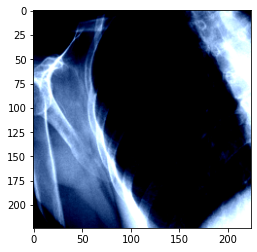

In [6]:
inputs , classs = next(iter(trainloader))
x = inputs[0]
x = x.numpy().transpose((1, 2, 0))
plt.imshow(x)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


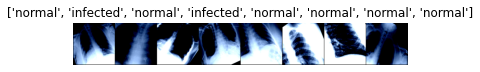

tensor([1, 0, 1, 0, 1, 1, 1, 1])


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    class_names = ['infected','normal']
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)
print(classes)

# Load the pretrained model from pytorch


In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

FClayers = list(vgg16.classifier.children())[:-3] 

FClayers[0].out_features = (10*10)+100
FClayers[3].in_features  = (10*10)+100
FClayers[3].out_features = 2
FClayers
vgg16.classifier = nn.Sequential(*FClayers)

for param in vgg16.parameters():
    param.requires_grad = True


### Learnable Parameters in FC layers

In [0]:

for name, param in vgg16.named_parameters():
  if param.requires_grad:
    print(name)

features.0.weight
features.0.bias
features.2.weight
features.2.bias
features.5.weight
features.5.bias
features.7.weight
features.7.bias
features.10.weight
features.10.bias
features.12.weight
features.12.bias
features.14.weight
features.14.bias
features.17.weight
features.17.bias
features.19.weight
features.19.bias
features.21.weight
features.21.bias
features.24.weight
features.24.bias
features.26.weight
features.26.bias
features.28.weight
features.28.bias
classifier.0.weight
classifier.0.bias
classifier.3.weight
classifier.3.bias


### Freezing the layers

### Training

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start = time.time()

    trainErr = []
    trainAcc = []
    validErr = []
    validAcc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (preds == labels).sum().item()

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total

            print('Epoch {}/{},{} ==> Loss: {:.4f} , Acc: {:.2f} %'.format(
                epoch+1, num_epochs,phase, epoch_loss, epoch_acc*100))
            
            
            if phase == 'train':
                trainErr.append(epoch_loss)
                trainAcc.append(epoch_acc*100)
            else:
                validErr.append(epoch_loss)
                validAcc.append(epoch_acc*100)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    endtime = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format( endtime // 60, endtime % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, trainErr, trainAcc, validErr, validAcc

### Loss fucntion and optimizer

Epoch 1/30,train ==> Loss: 0.3813 , Acc: 84.56 %
Epoch 1/30,val ==> Loss: 0.3127 , Acc: 87.47 %

Epoch 2/30,train ==> Loss: 0.3556 , Acc: 85.32 %
Epoch 2/30,val ==> Loss: 0.3138 , Acc: 87.07 %

Epoch 3/30,train ==> Loss: 0.3436 , Acc: 85.64 %
Epoch 3/30,val ==> Loss: 0.3192 , Acc: 87.67 %

Epoch 4/30,train ==> Loss: 0.3344 , Acc: 85.98 %
Epoch 4/30,val ==> Loss: 0.2925 , Acc: 88.00 %

Epoch 5/30,train ==> Loss: 0.3307 , Acc: 86.67 %
Epoch 5/30,val ==> Loss: 0.2906 , Acc: 88.00 %

Epoch 6/30,train ==> Loss: 0.3287 , Acc: 86.19 %
Epoch 6/30,val ==> Loss: 0.2950 , Acc: 88.53 %

Epoch 7/30,train ==> Loss: 0.3206 , Acc: 86.94 %
Epoch 7/30,val ==> Loss: 0.2814 , Acc: 88.80 %

Epoch 8/30,train ==> Loss: 0.3196 , Acc: 86.84 %
Epoch 8/30,val ==> Loss: 0.2891 , Acc: 87.87 %

Epoch 9/30,train ==> Loss: 0.3168 , Acc: 87.09 %
Epoch 9/30,val ==> Loss: 0.2879 , Acc: 88.60 %

Epoch 10/30,train ==> Loss: 0.3078 , Acc: 87.27 %
Epoch 10/30,val ==> Loss: 0.3105 , Acc: 88.00 %

Epoch 11/30,train ==> Loss: 

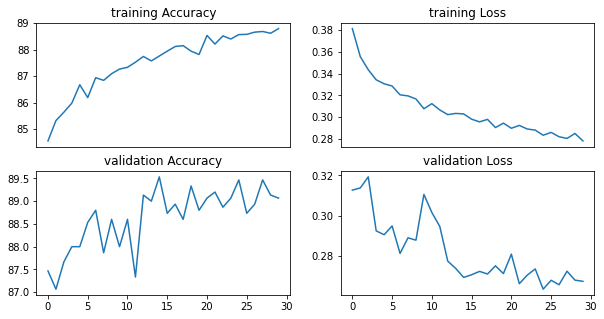

In [0]:
Epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    vgg16.cuda()
model, trainErr, trainAcc, validErr, validAcc = train_model( vgg16, criterion, optimizer, Epochs  )

testAccuracy(model,testloader)
plotEvaluations(trainAcc,trainErr,validAcc,validErr)

torch.save(model, 'vgg16_FC_Only.pth')


Epoch 1/10,train ==> Loss: 0.4406 , Acc: 84.53 %
Epoch 1/10,val ==> Loss: 0.2604 , Acc: 88.27 %

Epoch 2/10,train ==> Loss: 0.2865 , Acc: 88.78 %
Epoch 2/10,val ==> Loss: 0.2426 , Acc: 89.73 %

Epoch 3/10,train ==> Loss: 0.2607 , Acc: 89.83 %
Epoch 3/10,val ==> Loss: 0.2522 , Acc: 89.87 %

Epoch 4/10,train ==> Loss: 0.2474 , Acc: 90.45 %
Epoch 4/10,val ==> Loss: 0.2211 , Acc: 91.00 %

Epoch 5/10,train ==> Loss: 0.2328 , Acc: 90.96 %
Epoch 5/10,val ==> Loss: 0.2161 , Acc: 91.07 %

Epoch 6/10,train ==> Loss: 0.2255 , Acc: 91.30 %
Epoch 6/10,val ==> Loss: 0.2382 , Acc: 89.87 %

Epoch 7/10,train ==> Loss: 0.2212 , Acc: 91.57 %
Epoch 7/10,val ==> Loss: 0.2122 , Acc: 91.27 %

Epoch 8/10,train ==> Loss: 0.2242 , Acc: 91.42 %
Epoch 8/10,val ==> Loss: 0.2253 , Acc: 90.40 %

Epoch 9/10,train ==> Loss: 0.2162 , Acc: 91.46 %
Epoch 9/10,val ==> Loss: 0.2400 , Acc: 90.60 %

Epoch 10/10,train ==> Loss: 0.2093 , Acc: 91.97 %
Epoch 10/10,val ==> Loss: 0.2034 , Acc: 91.73 %

Training complete in 133m 28

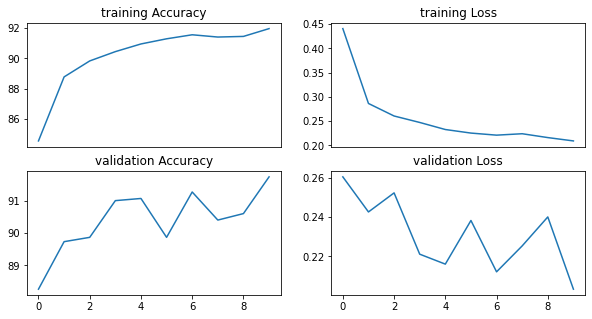

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    vgg16.cuda()
model, trainErr, trainAcc, validErr, validAcc = train_model( vgg16, criterion, optimizer, Epochs  )

testAccuracy(model,testloader)
plotEvaluations(trainAcc,trainErr,validAcc,validErr)

torch.save(model, '/content/drive/My Drive/vgg16_entire.pth')
torch.save(model, 'vgg16_entire.pth')

## Model evaluation

In [0]:
def misClassification(actual,predict):
  infected_T = np.where( (actual==0) & (predict==0) )[0]
  infected_F = np.where( (actual==0) & (predict==1) )[0]
  normal_T   = np.where( (actual==1) & (predict==1) )[0]
  normal_F   = np.where( (actual==1) & (predict==0) )[0]
  print( len(infected_T), len(infected_F), len(normal_T), len(normal_F) )

  print('Actuall   = Infected')
  print('Actuall   =  Normal')

  plt.imshow(np.array(test_data[infected_F[0]][0]).transpose((1, 2, 0)))
  plt.title('Prediction = '+class_names[1])
  plt.show()


  print('Actuall   = Normal')
  print('Actuall   = Infected')

  plt.imshow(np.array(test_data[normal_F[0]][0]).transpose((1, 2, 0)))
  plt.title('Prediction = '+class_names[0])
  plt.show()



def calculateF1(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  tn = ((1 - y_true) * (1 - y_pred)).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()
  epsilon = 1e-7

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)
  f1 = 2* (precision*recall) / (precision + recall + epsilon)

  print("\n precision = ",precision, "\n Recall    = ", recall, "\n F1 score = ", f1)

def confusion_mat(model,testloader ):

  classes = 2
  actual  = []
  predict = []

  confusion_matrix = torch.zeros(classes, classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(testloader):
          inputs  = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _,preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
          actual.extend( np.array(classes.cpu()) )
          predict.extend(np.array(preds.cpu()) )
      actual  = np.array(actual)
      predict = np.array(predict)
      misClassification(actual,predict)
      calculateF1(actual,predict)
  return confusion_matrix

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


573 42 881 4
Actuall   = Infected
Actuall   =  Normal


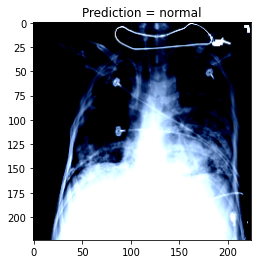

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actuall   = Normal
Actuall   = Infected


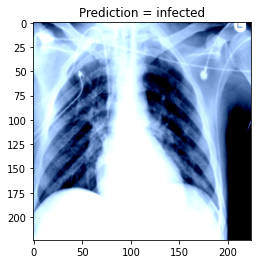


 precision =  0.9544962079139224 
 Recall    =  0.995480225876217 
 F1 score =  0.9745574720381786


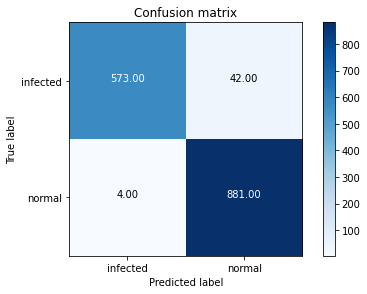

In [12]:

path  = '/content/drive/My Drive/vgg16_entire.pth'
model = loadTrainedModel(path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classes = ['infected', 'normal']
cm = confusion_mat(model,testloader)

plot_confusion_matrix(cm, classes)


### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


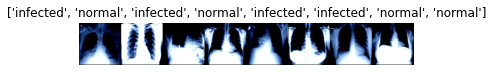

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [0]:
images, labels = inputs.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal infected normal infected
Ground Truth:  infected normal infected normal infected infected normal normal


In [0]:
def testAccuracy(model,testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on  test data: %d %%' % (
      100 * correct / total))
  
def plotEvaluations(trainAcc,trainErr,validAcc,validErr):
  fig,ax = plt.subplots(2,2)
  fig.set_size_inches(10,5)

  ax[0][0].plot(trainAcc)
  ax[0][0].set_title('training Accuracy')
  ax[0][0].xaxis.set_visible(False) 


  ax[0][1].plot(trainErr)
  ax[0][1].set_title('training Loss')
  ax[0][1].xaxis.set_visible(False) 


  ax[1][0].plot(validAcc)
  ax[1][0].set_title('validation Accuracy')

  ax[1][1].plot(validErr)
  ax[1][1].set_title('validation Loss')
